# Load and Inspect the Data

In [51]:
#Imports
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

df = pd.read_csv('../data/kickstarter_projects.csv')

df.columns = [col.lower() for col in df.columns]

print(df.head())
print(df.info())
print(df.describe())

           id                                               name   
0  1860890148  Grace Jones Does Not Give A F$#% T-Shirt (limi...  \
1   709707365                     CRYSTAL ANTLERS UNTITLED MOVIE   
2  1703704063                                drawing for dollars   
3      727286                       Offline Wikipedia iPhone app   
4  1622952265                                         Pantshirts   

       category   subcategory        country             launched    deadline   
0       Fashion       Fashion  United States  2009-04-21 21:02:48  2009-05-31  \
1  Film & Video        Shorts  United States  2009-04-23 00:07:53  2009-07-20   
2           Art  Illustration  United States  2009-04-24 21:52:03  2009-05-03   
3    Technology      Software  United States  2009-04-25 17:36:21  2009-07-14   
4       Fashion       Fashion  United States  2009-04-27 14:10:39  2009-05-26   

    goal  pledged  backers       state  
0   1000      625       30      Failed  
1  80000       22     

## Key Questions to Explore
### Project Success Rate:

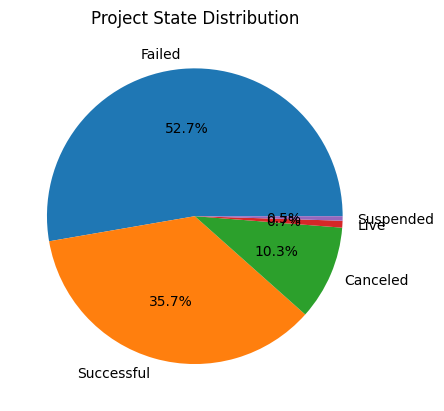

In [52]:
state_counts = df['state'].value_counts()
plt.pie(state_counts, labels=state_counts.index, autopct='%1.1f%%')
plt.title('Project State Distribution')
plt.show()

### Funding Goals vs. Pledged Amounts:

* Use logarithmic scales due to wide ranges; look for patterns in successful projects.

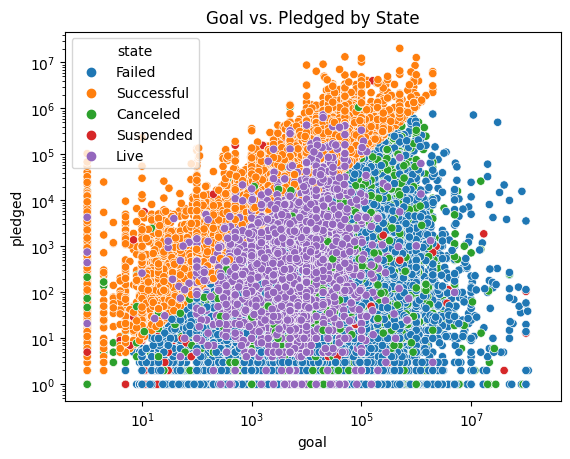

In [53]:
sns.scatterplot(x='goal', y='pledged', hue='state', data=df)
plt.xscale('log')
plt.yscale('log')
plt.title('Goal vs. Pledged by State')
plt.show()

### Category Insights:

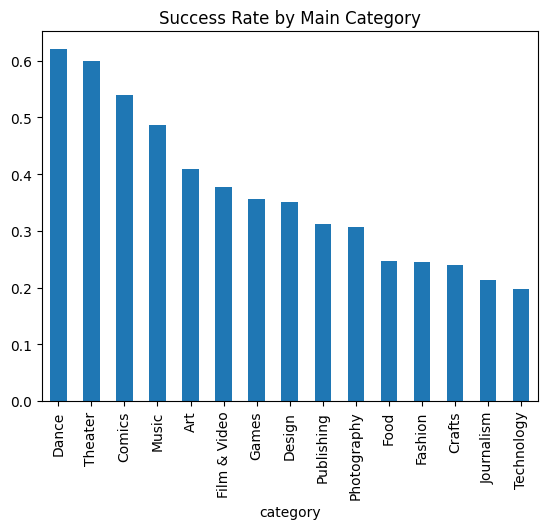

In [54]:
success_by_category = df[df['state'] == 'Successful']['category'].value_counts()
total_by_category = df['category'].value_counts()
success_rate = (success_by_category / total_by_category).sort_values(ascending=False)
success_rate.plot(kind='bar', title='Success Rate by Main Category')
plt.show()

### Time Trends:

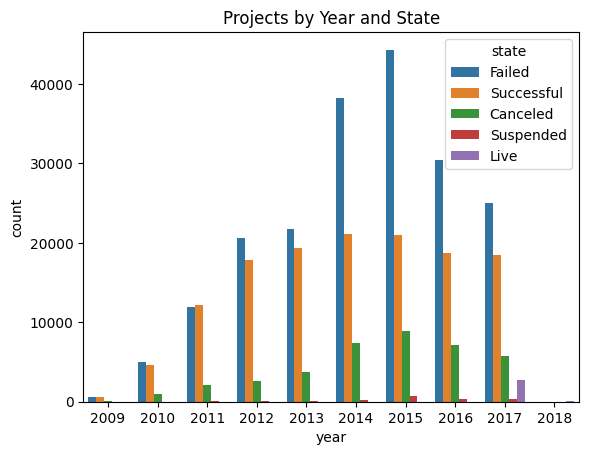

In [55]:
df['launched'] = pd.to_datetime(df['launched'])
df['year'] = df['launched'].dt.year
sns.countplot(x='year', hue='state', data=df)
plt.title('Projects by Year and State')
plt.show()

In [37]:
df.columns

Index(['id', 'name', 'category', 'subcategory', 'country', 'launched',
       'deadline', 'goal', 'pledged', 'backers', 'state', 'year',
       'duration_days', 'success'],
      dtype='object')

## Step 1: Data Preparation
First, let’s clean and prepare the data to focus on success factors. Assuming you’re using the ks-projects-201801.csv dataset from Kaggle, here’s how to start:

* Notes:
** We drop pledged because it’s a result of success, not a predictor. We’ll use goal instead.
** If there are missing values (e.g., in usd_goal_real), we might drop those rows or impute them later.

In [56]:
# Filter to only 'Successful' and 'Failed' projects (exclude 'live', 'canceled', etc.)
df = df[df['state'].isin(['Successful', 'Failed'])]

In [57]:
# Convert dates and calculate campaign duration
df['launched'] = pd.to_datetime(df['launched'])
df['deadline'] = pd.to_datetime(df['deadline'])
df['duration_days'] = (df['deadline'] - df['launched']).dt.days

In [58]:
# Create a binary target: 1 for successful, 0 for failed
df['success'] = (df['state'] == 'Successful').astype(int)

In [59]:
# Drop unnecessary columns (e.g., 'ID', 'name' for now)
df = df.drop(columns=['id', 'name', 'state', 'pledged'])  # Pledged is outcome-related, not a predictor

# Check for missing values
print(df.isnull().sum())

category         0
subcategory      0
country          0
launched         0
deadline         0
goal             0
backers          0
year             0
duration_days    0
success          0
dtype: int64


## Step 2: Feature Exploration
Let’s examine key features that might influence success: goal, category, main_category, country, currency, duration_days, and launched (time-based factors). We’ll visualize and analyze each.

a. Funding Goal (goal and usd_goal_real)
Higher goals might be harder to achieve. Let’s compare distributions:

In [60]:
df.info()
df['state'].head(5)

<class 'pandas.core.frame.DataFrame'>
Index: 331462 entries, 0 to 374605
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   category       331462 non-null  object        
 1   subcategory    331462 non-null  object        
 2   country        331462 non-null  object        
 3   launched       331462 non-null  datetime64[ns]
 4   deadline       331462 non-null  datetime64[ns]
 5   goal           331462 non-null  int64         
 6   backers        331462 non-null  int64         
 7   year           331462 non-null  int32         
 8   duration_days  331462 non-null  int64         
 9   success        331462 non-null  int64         
dtypes: datetime64[ns](2), int32(1), int64(4), object(3)
memory usage: 26.6+ MB


KeyError: 'state'

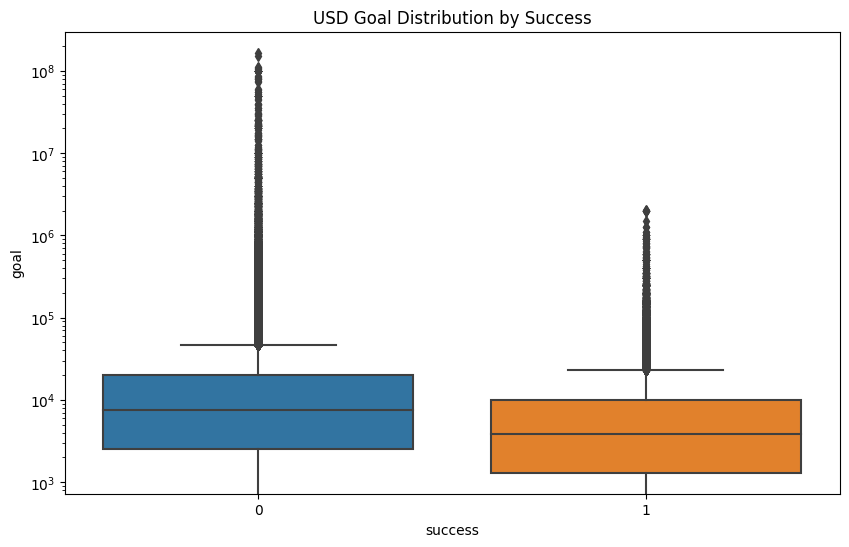

success
0    7500.0
1    3840.0
Name: goal, dtype: float64


In [63]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='success', y='goal')  # Exclude outliers for clarity
plt.yscale('log')
plt.title('USD Goal Distribution by Success')
plt.show()

# Median goals by success
print(df.groupby('success')['goal'].median())

b. Category (main_category)
Some categories might inherently perform better:

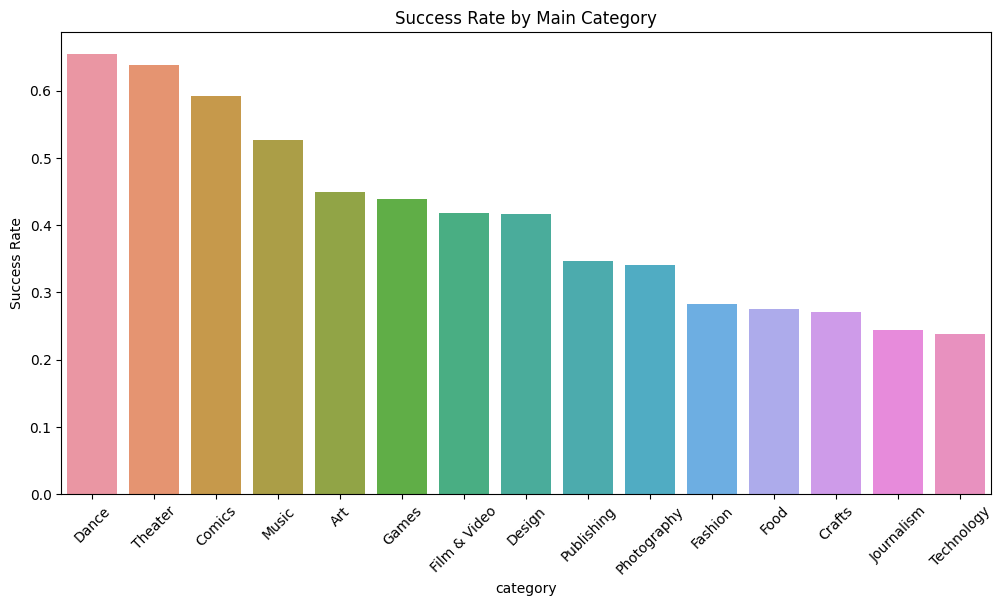

category
Dance           0.654352
Theater         0.637961
Comics          0.591415
Music           0.526299
Art             0.448908
Games           0.438920
Film & Video    0.417889
Design          0.415921
Publishing      0.347330
Photography     0.341108
Fashion         0.282846
Food            0.275914
Crafts          0.270530
Journalism      0.243973
Technology      0.237854
Name: success, dtype: float64


In [77]:
plt.figure(figsize=(12, 6))
success_rate = df.groupby('category')['success'].mean().sort_values(ascending=False)
sns.barplot(x=success_rate.index, y=success_rate.values)
plt.xticks(rotation=45)
plt.title('Success Rate by Main Category')
plt.ylabel('Success Rate')
plt.show()

print(df.groupby('category')['success'].mean().sort_values(ascending=False))

Expectation: Categories like Music or Art might have higher success rates due to lower goals or broader appeal.

c. Campaign Duration (duration_days)
Longer campaigns might signal uncertainty, or shorter ones might create urgency:

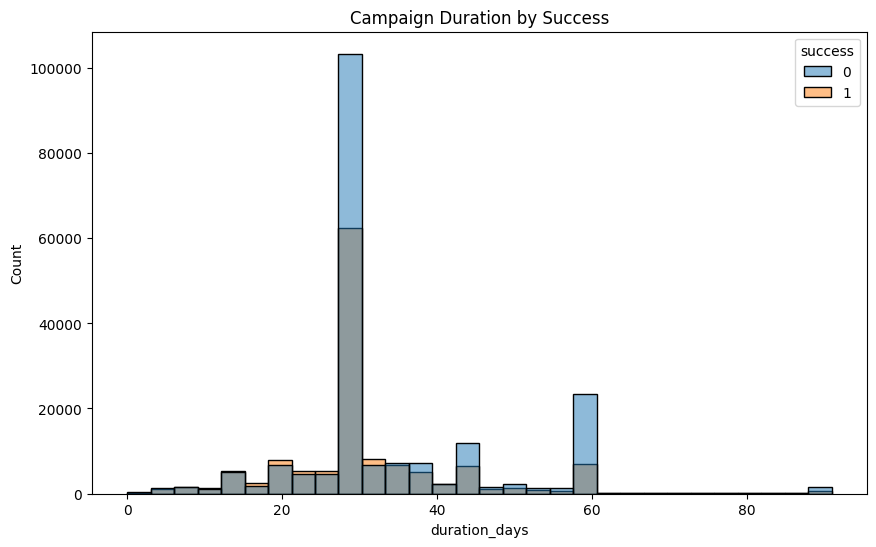

success
0    29.0
1    29.0
Name: duration_days, dtype: float64


In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='duration_days', hue='success', bins=30, alpha=0.5)
plt.title('Campaign Duration by Success')
plt.show()

# Median duration by success
print(df.groupby('success')['duration_days'].median())

Expectation: Successful projects might favor shorter durations (e.g., 30 days).

d. Country (country)
Geographic differences could reflect market size or crowdfunding culture:

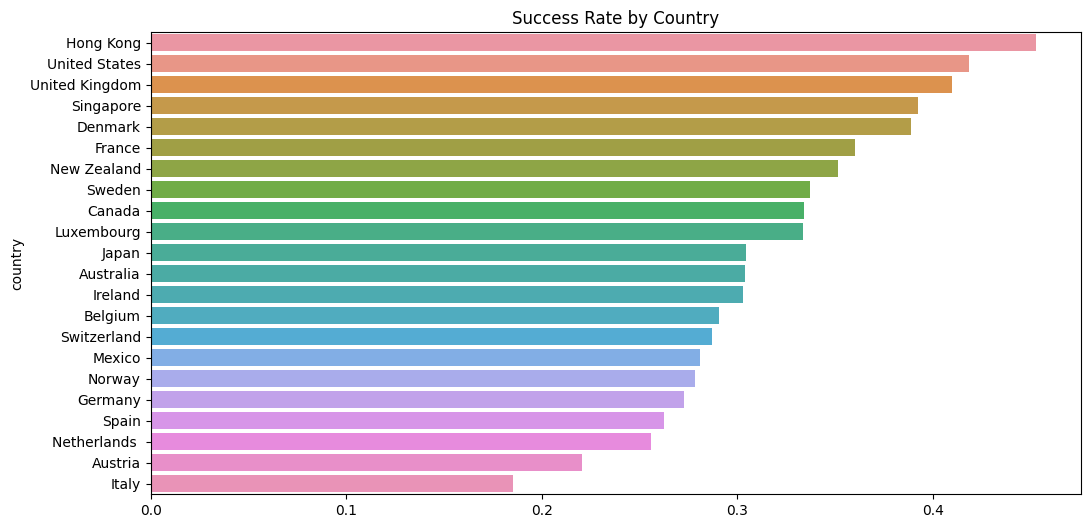

country
Hong Kong         0.452830
United States     0.418196
United Kingdom    0.409704
Singapore         0.392070
Denmark           0.388769
France            0.360317
New Zealand       0.351648
Sweden            0.337309
Canada            0.334196
Luxembourg        0.333333
Japan             0.304348
Australia         0.303809
Ireland           0.303075
Belgium           0.290631
Switzerland       0.286810
Mexico            0.280652
Norway            0.278351
Germany           0.272701
Spain             0.262680
Netherlands       0.255910
Austria           0.220619
Italy             0.185310
Name: success, dtype: float64


In [79]:
plt.figure(figsize=(12, 6))
success_rate_country = df.groupby('country')['success'].mean().sort_values(ascending=False)
sns.barplot(y=success_rate_country.index, x=success_rate_country.values, orient='h')
plt.title('Success Rate by Country')
plt.show()

print(success_rate_country)

e. Launch Timing (launched)
Seasonality or year might matter:

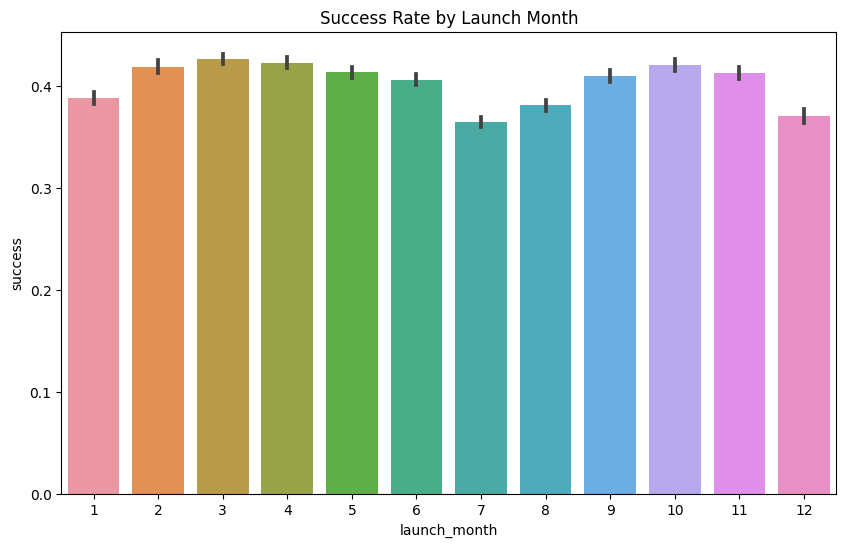

launch_month
3     0.426626
4     0.422958
10    0.420426
2     0.418795
5     0.413366
11    0.412939
9     0.409801
6     0.406344
1     0.388334
8     0.380919
12    0.370599
7     0.364951
Name: success, dtype: float64


In [80]:
df['launch_month'] = df['launched'].dt.month
df['launch_year'] = df['launched'].dt.year

plt.figure(figsize=(10, 6))
sns.barplot(x='launch_month', y='success', data=df)
plt.title('Success Rate by Launch Month')
plt.show()

print(df.groupby('launch_month')['success'].mean().sort_values(ascending=False))

## Step 3: Correlation and Feature Importance
To quantify importance, let’s use a simple machine learning model (e.g., Random Forest) to rank features. First, encode categorical variables:

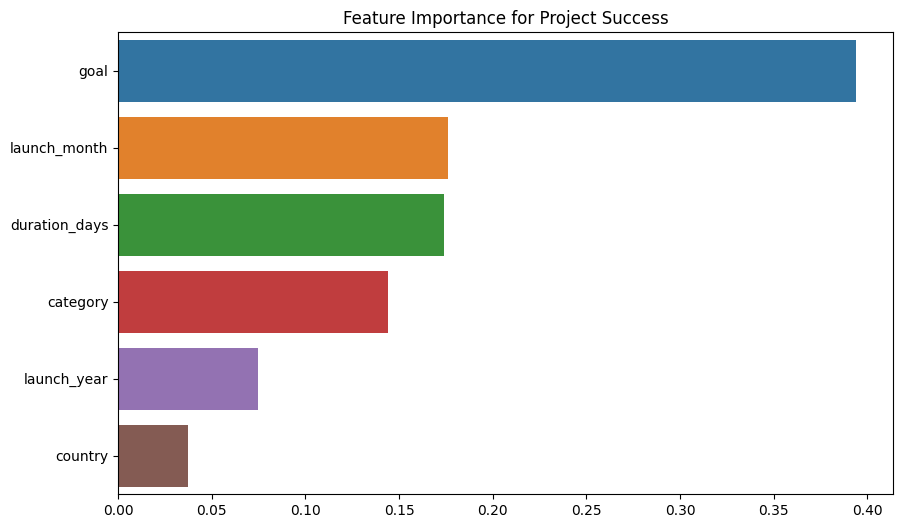

goal             0.394201
launch_month     0.176288
duration_days    0.173741
category         0.144060
launch_year      0.074472
country          0.037238
dtype: float64
Precision: 0.552
Recall: 0.495
F1-Score: 0.522
Accuracy: 0.633

Classification Report:
              precision    recall  f1-score   support

      Failed       0.68      0.73      0.70     39502
  Successful       0.55      0.49      0.52     26791

    accuracy                           0.63     66293
   macro avg       0.62      0.61      0.61     66293
weighted avg       0.63      0.63      0.63     66293



In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

# Select features
features = ['goal', 'category', 'country', 'duration_days', 'launch_month', 'launch_year']
X = df[features].copy()
y = df['success']

# Encode categorical variables
le = LabelEncoder()
X['category'] = le.fit_transform(X['category'])
X['country'] = le.fit_transform(X['country'])

# # Handle any NaN values (simple imputation)
X = X.fillna(X.median())

# Train/test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)

# Feature importance
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index)
plt.title('Feature Importance for Project Success')
plt.show()
print(importances)


# Calculate metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print results
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Failed', 'Successful']))

##  Digging Deeper

* Duration: Bucket into ranges (<20, 20-40, >40 days) to check if extremes matter:

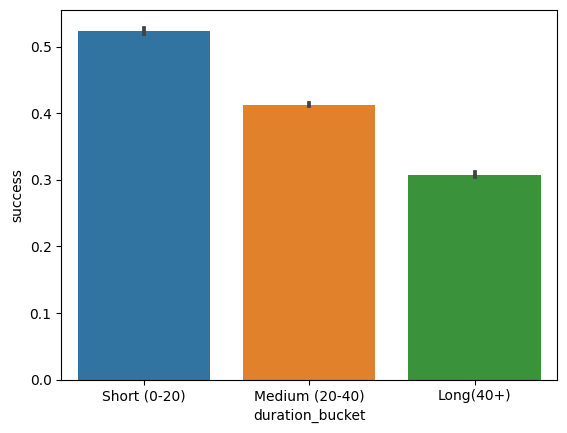

In [82]:
df['duration_bucket'] = pd.cut(df['duration_days'], bins=[0, 20, 40, 100], labels=['Short (0-20)', 'Medium (20-40)', 'Long(40+)'])
sns.barplot(x='duration_bucket', y='success', data=df)
plt.show()

* Goal + Category: Test if low goals in low-success categories (e.g., Tech) still fail, or if goal trumps all:

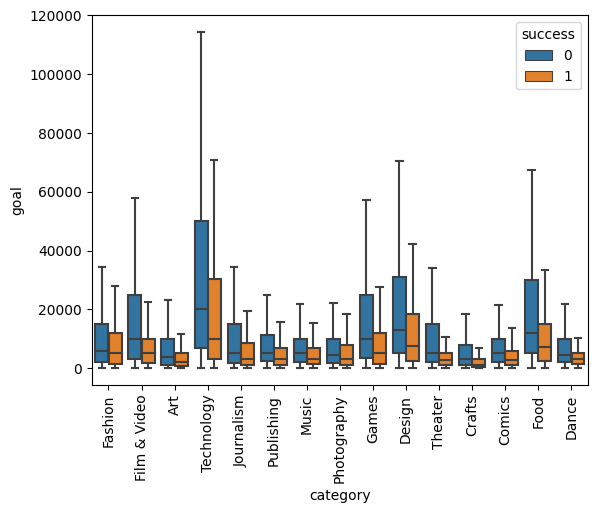

In [85]:
sns.boxplot(x='category', y='goal', hue='success', data=df, showfliers=False)
plt.xticks(rotation=90)
plt.show()